In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nested_pandas.utils import count_nested
import nested_pandas as npd
from dask.distributed import Client


import os
from numba import njit
import lsdb
import hats



from upath import UPath

import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [2]:
def calcSF_fixed_bins(tclip, fclip, bin_edges):
    """
    Compute the structure function (SF) using predefined time lag bins.
    Vectorized pairwise differences + Numba-accelerated binning.
    """
    if len(tclip) > 50:
        idx = np.random.choice(len(tclip), size=50, replace=False)
        tclip = tclip[idx]
        fclip = fclip[idx]
    
    # Compute pairwise time and magnitude differences (upper triangle)
    dt_matrix = np.abs(tclip[:, None] - tclip[None, :])
    df2_matrix = (fclip[:, None] - fclip[None, :])**2

    i_upper, j_upper = np.triu_indices(len(tclip), k=1)
    all_dt = dt_matrix[i_upper, j_upper]
    all_df2 = df2_matrix[i_upper, j_upper]

    # Use Numba for fast binning
    return _compute_binned_sf(all_dt, all_df2, bin_edges)

@njit
def _compute_binned_sf_njit(all_dt, all_df2, bin_edges):
    n_bins = len(bin_edges) - 1
    tau_median = np.empty(n_bins)
    SF = np.empty(n_bins)
    N = np.empty(n_bins, dtype=np.int64)

    for i in range(n_bins):
        lo = bin_edges[i]
        hi = bin_edges[i + 1]

        # Count how many points are in the bin first
        count = 0
        for j in range(len(all_dt)):
            if lo <= all_dt[j] < hi:
                count += 1

        N[i] = count

        if count > 0:
            dt_bin = np.empty(count)
            df2_bin = np.empty(count)

            idx = 0
            for j in range(len(all_dt)):
                if lo <= all_dt[j] < hi:
                    dt_bin[idx] = all_dt[j]
                    df2_bin[idx] = all_df2[j]
                    idx += 1

            tau_median[i] = np.median(dt_bin)
            SF[i] = np.sqrt(np.mean(df2_bin)) / np.sqrt(2)
        else:
            tau_median[i] = np.nan
            SF[i] = np.nan

    return tau_median, SF, N, np.arange(len(bin_edges) - 1)


def _compute_binned_sf(all_dt, all_df2, bin_edges):
    tau_median, SF, N, N_edges =_compute_binned_sf_njit(all_dt, all_df2, bin_edges)
    return {'lc.tau_median':tau_median, 'lc.SF':SF, 'lc.N':N, 'lc.time_step':np.arange(len(bin_edges) - 1)}

In [3]:
!aws s3 ls s3://rubin-lincc-hats/hats/w_2025_18/ 


                           PRE dia_object/
                           PRE dia_object_collection/
                           PRE dia_object_forced_source/
                           PRE dia_source/


In [4]:
!aws s3 ls s3://rubin-lincc-hats/hats/w_2025_19/ 

                           PRE dia_object/
                           PRE dia_object_collection/
                           PRE dia_object_forced_source/
                           PRE dia_source/


In [5]:
!aws s3 ls s3://rubin-lincc-hats/hats/w_2025_19/dia_object 

                           PRE dia_object/
                           PRE dia_object_collection/
                           PRE dia_object_forced_source/


In [ ]:
# Start with a small client
client = Client(n_workers=8, memory_limit="32GB", threads_per_worker=1)
# client.close()

INFO:distributed.scheduler:State start


INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:11383
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:25887'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:6531'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:9425'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:5397'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:6823'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:24465'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:24719'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:7479'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:1817 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:1817
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:117

INFO:distributed.core:Connection to tcp://127.0.0.1:11796 has been closed.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:27877 name: 0 (stimulus_id='handle-worker-cleanup-1747850423.2760174')


In [7]:

# If the AWS_ENDPOINT_URL is not set, add the following to UPath:
# endpoint_url=os.env["LSST_RESOURCES_S3_PROFILE_embargo"]
dia_object_lc = lsdb.read_hats(UPath("s3://rubin-lincc-hats/hats/w_2025_19/dia_object_collection"), 
                               columns = ["diaObjectId", "ra", "dec", 'tract', "diaObjectForcedSource"])
dia_object_lc_thumbnail = npd.read_parquet(UPath("s3://rubin-lincc-hats/hats/w_2025_19/dia_object_collection/dia_object_lc/dataset/data_thumbnail.parquet"))
dia_object_lc_hats = hats.read_hats(UPath("s3://rubin-lincc-hats/hats/w_2025_19/dia_object_collection")).main_catalog

dia_object_lc

INFO:aiobotocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini
INFO:botocore.configprovider:Found endpoint for s3 via: environment_global.


,diaObjectId,ra,dec,tract,diaObjectForcedSource
npartitions=202,,,,,
"Order: 5, Pixel: 6421",int64[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],"nested<parentObjectId: [int64], coord_ra: [dou..."
"Order: 5, Pixel: 6422",...,...,...,...,...
...,...,...,...,...,...
"Order: 8, Pixel: 443989",...,...,...,...,...
"Order: 6, Pixel: 27760",...,...,...,...,...


In [8]:
from lsdb.core.search import ConeSearch
dia_object_lc = lsdb.read_hats(UPath("s3://rubin-lincc-hats/hats/w_2025_19/dia_object_collection"), 
                               columns = ["diaObjectId", "ra", "dec", 'tract', "diaObjectForcedSource"],
                                search_filter = ConeSearch(ra=182, dec=7.0, radius_arcsec=7.5 * 3600))


(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Coverage MOC of dia_object_lc'}>)

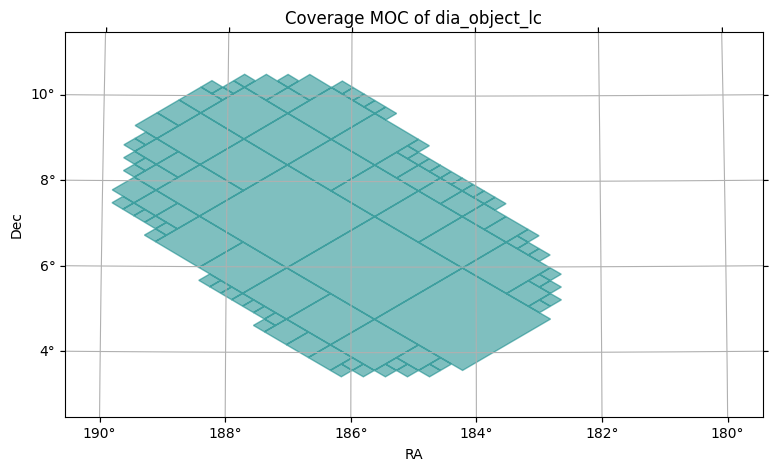

In [9]:
import astropy.units as u
from astropy.coordinates import SkyCoord
fov = (10 * u.deg, 10 * u.deg)
center = SkyCoord(185 * u.deg, 7 * u.deg)
dia_object_lc.plot_coverage(fov=fov, center=center)

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - dia_object_lc'}>)

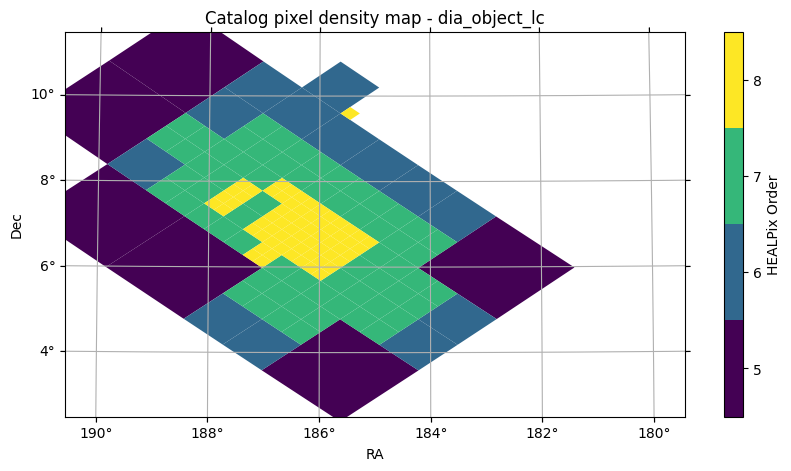

In [10]:
import astropy.units as u
from astropy.coordinates import SkyCoord
fov = (10 * u.deg, 10 * u.deg)
center = SkyCoord(185 * u.deg, 7 * u.deg)
dia_object_lc.plot_pixels(fov=fov, center=center)

# Nested version

In [37]:
test = dia_object_lc.head(100)
test.iloc[1].diaObjectForcedSource
test.diaObjectForcedSource.nest.fields

['parentObjectId',
 'coord_ra',
 'coord_dec',
 'visit',
 'detector',
 'band',
 'psfFlux',
 'psfFluxErr',
 'psfFlux_flag',
 'psfDiffFlux',
 'psfDiffFluxErr',
 'psfDiffFlux_flag',
 'diff_PixelFlags_nodataCenter',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_nodata',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'invalidPsfFlag',
 'tract',
 'patch',
 'forcedSourceOnDiaObjectId',
 'psfMag',
 'psfMagErr',
 'midpointMjdTai']

In [38]:
dia_object_lc_computed = dia_object_lc.compute()

In [39]:
len(dia_object_lc_computed)

2415

In [50]:
# Identify flag columns
flag_cols = [col for col in dia_object_lc_computed.diaObjectForcedSource.nest.fields if 'flag' in col.lower()]

# Build the condition string, e.g., "flag1 == False & flag2 == False & ..."
query_str = " & ".join([f"diaObjectForcedSource.{col} == False" for col in flag_cols])
query_str = query_str + '& diaObjectForcedSource.band == "r"'
# Apply query directly to the nested column
dia_object_lc_computed_filtered = dia_object_lc_computed.query(query_str)
dia_object_lc_computed_filtered = dia_object_lc_computed_filtered.dropna(subset = 'diaObjectForcedSource.psfMag')
dia_object_lc_computed_filtered = dia_object_lc_computed_filtered.dropna(subset = 'diaObjectForcedSource')
dia_object_lc_computed_filtered = count_nested(dia_object_lc_computed_filtered, nested='diaObjectForcedSource') 
dia_object_lc_computed_filtered = dia_object_lc_computed_filtered[dia_object_lc_computed_filtered['n_diaObjectForcedSource'] > 5]

In [51]:
bin_edges= np.arange(-0.5, 10, 1.0)
bin_edges

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

In [52]:
result = dia_object_lc_computed_filtered.reduce(calcSF_fixed_bins, "diaObjectForcedSource.midpointMjdTai", "diaObjectForcedSource.psfMag", bin_edges=bin_edges)
dia_object_lc_computed_filtered = dia_object_lc_computed_filtered.join(result, how='left')

In [53]:
result = dia_object_lc_computed_filtered.reduce(np.median, 'diaObjectForcedSource.psfMag').rename(columns={0:'median_psfMag'})
dia_object_lc_computed_filtered = dia_object_lc_computed_filtered.join(result, how='left')

In [7]:
dia_object_lc_computed_filtered.head(6)

NameError: name 'dia_object_lc_computed_filtered' is not defined

In [58]:
dia_object_lc_computed_filtered.to_parquet('dia_object_lc_computed_filtered.parquet')

In [50]:
single_mag_flat = single_mag['lc'].nest.to_flat()

In [68]:
single_mag_flat

In [69]:
import numpy as np
import pandas as pd

results = []

# Loop over magnitude bins
for mag_bin in tqdm(range(15, 25)):  # 15 to 24 inclusive
    # Filter by magnitude bin
    mag_mask = (
        (dia_object_lc_computed_filtered['median_psfMag'] >= mag_bin) &
        (dia_object_lc_computed_filtered['median_psfMag'] < mag_bin + 1)
    )
    single_mag = dia_object_lc_computed_filtered[mag_mask]

    if single_mag.empty:
        continue

    # Flatten nested structure
    single_mag_flat = single_mag['lc'].nest.to_flat()

    for i in range(10):  # Loop over time_step
        subset = single_mag_flat[single_mag_flat['time_step'] == i]
        subset = subset[subset['N'] > 10] 
        if not subset.empty:
            tau_vals = subset['tau_median'].dropna()
            sf_vals = subset['SF'].dropna()

            if len(tau_vals) > 0 and len(sf_vals) > 0:
                tau_med = np.median(tau_vals)
                sf_med = np.median(sf_vals)
                sf_q16 = np.quantile(sf_vals, 0.16)
                sf_q84 = np.quantile(sf_vals, 0.84)

                results.append((
                    mag_bin,  # add mag_bin info
                    i,
                    tau_med,
                    sf_med,
                    sf_q16,
                    sf_q84
                ))

# Create results DataFrame
result_df = pd.DataFrame(results, columns=[
    'mag_bin', 'time_step', 'tau_median', 'SF_median', 'SF_16', 'SF_84'
])

# Drop rows with any remaining NaNs (just in case)
result_df = result_df.dropna()

result_df

In [60]:
result_df.columns

In [70]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

# Define a color map for consistent coloring (optional)
colors = plt.cm.viridis(np.linspace(0, 1, len(result_df['mag_bin'].unique())))

for idx, mag_bin in enumerate(sorted(result_df['mag_bin'].unique())):
    single_bin = result_df[result_df['mag_bin'] == mag_bin]

    # Apply a small offset to x-values to avoid overlapping points
    offset = (idx - 5) * 0.06  # Centered around zero
    tau_offset = single_bin['tau_median'] + offset

    label = f"{mag_bin}–{mag_bin+1} mag"

    plt.errorbar(
        tau_offset,
        single_bin['SF_median'],
        yerr=[
            single_bin['SF_median'] - single_bin['SF_16'],
            single_bin['SF_84'] - single_bin['SF_median']
        ],
        fmt='o',
        capsize=2,
        label=label,
        alpha=0.8,
        color=colors[idx]
    )

plt.xticks(np.arange(0, 11, 1))
plt.xlim(-0.5, 10)
plt.xlabel("Time lag τ (days)", fontsize=12)
plt.ylabel("Structure Function SF (mag)", fontsize=12)
plt.title("Structure Function by Magnitude Bin", fontsize=14)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(title="Mag Bin", fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# LSDB 

In [18]:
bin_edges= np.arange(-0.5, 10, 1.0)
bin_edges

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5])

In [19]:
# lsdb.nested.count_nested(dia_object_lc_filtered, nested='diaObjectForcedSource') with default values doesnt work because join is not supported  

In [20]:
# Identify flag columns
flag_cols = [col for col in dia_object_lc['diaObjectForcedSource'].nest.fields if 'flag' in col.lower()]

# Build the condition string, e.g., "flag1 == False & flag2 == False & ..."
query_str = " & ".join([f"diaObjectForcedSource.{col} == False" for col in flag_cols])
query_str = query_str + '& diaObjectForcedSource.band == "r"'
# Apply query directly to the nested column
dia_object_lc_filtered = dia_object_lc.query(query_str)
dia_object_lc_filtered = dia_object_lc_filtered.dropna(subset = 'diaObjectForcedSource.psfMag')
dia_object_lc_filtered = dia_object_lc_filtered.dropna(subset = 'diaObjectForcedSource')
nested_length = lsdb.nested.count_nested(dia_object_lc_filtered, nested='diaObjectForcedSource', join=False) 
dia_object_lc_filtered = dia_object_lc_filtered.merge(nested_length)
dia_object_lc_filtered = dia_object_lc_filtered[dia_object_lc_filtered['n_diaObjectForcedSource'] > 5]

In [21]:
meta = dia_object_lc_thumbnail.reduce(calcSF_fixed_bins, "diaObjectForcedSource.midpointMjdTai", "diaObjectForcedSource.psfMag", bin_edges=bin_edges).head(0)
result = dia_object_lc_filtered.reduce(calcSF_fixed_bins, "diaObjectForcedSource.midpointMjdTai", "diaObjectForcedSource.psfMag", bin_edges=bin_edges, meta=meta)
dia_object_lc_filtered = dia_object_lc_filtered.join(result, how='left')

In [22]:
meta = dia_object_lc_thumbnail.reduce(np.median, 'diaObjectForcedSource.psfMag').head(0)
result = dia_object_lc_filtered.reduce(np.median, 'diaObjectForcedSource.psfMag', meta=meta).rename(columns={0:'median_psfMag'})
dia_object_lc_filtered = dia_object_lc_filtered.join(result, how='left')


In [ ]:
dia_object_lc_filtered_computed = dia_object_lc_filtered.compute()

In [ ]:
dia_object_lc_filtered_computed.to_parquet('dia_object_lc_filtered_computed.parquet')

In [107]:
client.close()

In [82]:
dia_object_lc_thumbnail

diaObjectId          ra       dec  nDiaSources   radecMjdTai  \
0    54431529291481121  211.796331  -9.13626            1  60798.174969   
1    54423420393226249  209.865125 -9.432436            1  60800.068368   
..                 ...         ...       ...          ...           ...   
200  75890147974971393  185.506223   9.52524            1  60795.173604   
201  75890147974971400  185.629217  9.601807            1  60795.175354   

     tract                                          diaSource  \
0     7920  [{visit: 2025050200506, detector: 72, band: 'r...   
1     7919  [{visit: 2025050400297, detector: 177, band: '...   
..     ...                                                ...   
200  11043  [{visit: 2025042900296, detector: 63, band: 'u...   
201  11043  [{visit: 2025042900299, detector: 63, band: 'u...   

                                 diaObjectForcedSource          _healpix_29  
0    [{parentObjectId: 0, coord_ra: 211.796331, coo...  1807559029927096890  
1    [{parentObjectId: 0, coord_ra: 209.865125, coo...  1807753648821066932  
..                                                 ...                  ...  
200  [{parentObjectId: 0, coord_ra: 185.506223, coo...  1952684666830007185  
201  [{parentObjectId: 0, coord_ra: 185.629217, coo...  1953436343433383732  

[202 rows x 9 columns]